# Project CF

In [65]:
'''Get some tools'''
import cv2
import os
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

## 1. Extract frames from the video

In [66]:
print(f'Extracting frames from the video at the specified time points.')
# Specify the path for your video file
video_path = os.environ.get('VIDEO_PATH', 'video/2143.mov')

# Get the filename without extension
f_vector = os.path.basename(video_path).split('.')[0]
filename = f_vector
# Create a new folder to store the frames
output_folder = f'ex_c/{filename}/original_frames'
if not os.path.exists(output_folder):
    os.makedirs(output_folder)

# Load the video
cap = cv2.VideoCapture(video_path)

# Get the frames per second of the video
fps = int(cap.get(cv2.CAP_PROP_FPS))

# Define the list of time points in seconds at which to start extracting frames
time_points = [60, 120, 180, 240, 300, 420, 600, 780, 960, 1200]

# Loop through the frames and save each frame as an image
frame_count = 0
extracting = False
current_time_point = 0
frame_in_interval = 0
while True:
    ret, frame = cap.read()
    if not ret:
        break

    # Check if the current frame is at one of the desired time points to start extraction
    current_time_in_seconds = frame_count / fps
    
    if int(current_time_in_seconds) in time_points:
        extracting = True
        current_time_point = int(current_time_in_seconds)
        time_points.remove(current_time_point)
        frame_in_interval = 0
    
    # If within one second of the time point, save the frame
    if extracting and current_time_in_seconds < current_time_point + 1:
        frame_in_interval += 1
        minute = str(current_time_point // 60).zfill(2)
        frame_file = os.path.join(output_folder, f'{filename}_{minute}_{frame_in_interval:02d}.png')
        cv2.imwrite(frame_file, frame)
    elif extracting and current_time_in_seconds >= current_time_point + 1:
        extracting = False
    
    frame_count += 1

# Release the video capture object
cap.release()

print('Fream extraction complete')


Extracting frames from the video at the specified time points.
Fream extraction complete


## 2. Enhance image

### 2.1 Generate the background.png

In [67]:
print('Extracting background.')
# Specify the path to your video file
video_file_path = video_path

# Specify the output directory for the frames
frames_dir = f'ex_c/{filename}/background'
if not os.path.exists(frames_dir):
    os.makedirs(frames_dir)

# Open the video file
cap = cv2.VideoCapture(video_file_path)

# Get the total number of frames in the video
total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))

# Get the frame rate of the video
frame_rate = int(cap.get(cv2.CAP_PROP_FPS))

# Define the time points (in minutes) where you want to start and end the frame extraction
start_minute = 0
end_minute = 20

# Calculate the frame numbers corresponding to the start and end time points
start_frame = start_minute * 60 * frame_rate
end_frame = min(end_minute * 60 * frame_rate, total_frames)

# List to store the frames
frames = []

# Loop to read and store the frames between start_frame and end_frame
step = 30  # We will read every 30th frame
for frame_num in range(start_frame, end_frame, step):
    cap.set(cv2.CAP_PROP_POS_FRAMES, frame_num)
    ret, frame = cap.read()
    if ret:
        # Convert frame to grayscale
        gray_frame = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
        frames.append(gray_frame)
    else:
        break

# Release the video file
cap.release()

# Calculate the median frame to get the background model
background_model = np.median(frames, axis=0).astype(np.uint8)

# Save the background model as an image
background_model_path = os.path.join(frames_dir, 'background_model.png')
cv2.imwrite(background_model_path, background_model)

print('Job complete.')

Extracting background.
Job complete.


### 2.2 Filter out the background noise

In [68]:
print('Reducing noise.')
# Load the background model
background_model_path = f'ex_c/{filename}/background/background_model.png'
background_model = cv2.imread(background_model_path, cv2.IMREAD_GRAYSCALE)

# Specify the directory containing the frames generated in your first script
input_frames_dir = f'ex_c/{filename}/original_frames'  

# Specify the output directory for the processed frames
output_dir = f'ex_c/{filename}/processed_frames'  
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

# Get a list of all PNG files in the input frames directory
input_files = [f for f in os.listdir(input_frames_dir) if os.path.isfile(os.path.join(input_frames_dir, f)) and f.endswith('.png')]

# Process each file in the input frames directory
for input_file in input_files:
    # Construct full input file path
    input_file_path = os.path.join(input_frames_dir, input_file)
    
    # Read the frame in grayscale
    gray_frame = cv2.imread(input_file_path, cv2.IMREAD_GRAYSCALE)

    if gray_frame is None:
        print(f"Could not read image: {input_file_path}")
        continue

    # Resize the gray frame to match the dimensions of the background model
    gray_frame = cv2.resize(gray_frame, (background_model.shape[1], background_model.shape[0]))

    # Subtract the background model from the frame
    foreground = cv2.absdiff(gray_frame, background_model)
    
    # Save the processed frame
    output_file_path = os.path.join(output_dir, input_file)
    cv2.imwrite(output_file_path, foreground)

print("Processing completed.")


Reducing noise.
Processing completed.


## 3. Cut out the counting zone for each frame

### 3.1 Make the mask

Generating region selection mask.


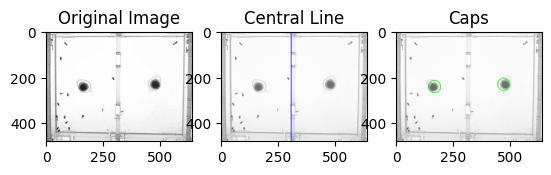

Confirm selected region.


In [69]:
print('Generating region selection mask.')
filename = f_vector
# Load the background image
background_img_path = f'ex_c/{filename}/background/background_model.png'
img = cv2.imread(background_img_path, cv2.IMREAD_GRAYSCALE)

# Apply edge detection
edges = cv2.Canny(img, 50, 150, apertureSize=3)

# Detect lines using Hough Line Transformation
lines = cv2.HoughLines(edges, 1, np.pi / 180, 200)

# Create a copy of the original image to draw the lines
img_with_lines = cv2.cvtColor(img, cv2.COLOR_GRAY2BGR)

# Define the central region of the image (middle 75%)
height, width = img.shape
central_region = (int(0.125 * width), int(0.875 * width))

# Lists to store rho and theta values of the detected lines
rhos = []
thetas = []

# Gather rho and theta values of the lines satisfying the conditions
if lines is not None:
    for rho, theta in lines[:, 0]:
        # Filter out horizontal lines
        if (np.pi / 4 < theta < 3 * np.pi / 4):
            continue
        
        a = np.cos(theta)
        b = np.sin(theta)
        x0 = a * rho

        # Check if the line is in the central region
        if central_region[0] < x0 < central_region[1]:
            rhos.append(rho)
            thetas.append(theta)

# Calculate the average rho and theta values
if rhos and thetas:
    rho_avg = np.mean(rhos)
    theta_avg = np.mean(thetas)

    # Draw the average line on the image
    a = np.cos(theta_avg)
    b = np.sin(theta_avg)
    x0 = a * rho_avg
    y0 = b * rho_avg
    x1 = int(x0 + 1000 * (-b))
    y1 = int(y0 + 1000 * (a))
    x2 = int(x0 - 1000 * (-b))
    y2 = int(y0 - 1000 * (a))
    
    cv2.line(img_with_lines, (x1, y1), (x2, y2), (0, 0, 255), 2)




# Calculate the x-coordinate of the central line
central_line_x = int((x1 + x2) / 2)


# Apply Hough Circle detection
circles = cv2.HoughCircles(img, cv2.HOUGH_GRADIENT, 1, 50,
                           param1=50, param2=30, minRadius=10, maxRadius=30)


detected_circle_left = None
detected_circle_right = None



# Create a copy of the original image to draw the circles
img_with_hough_circles = cv2.cvtColor(img, cv2.COLOR_GRAY2BGR)

if circles is not None:
    circles = np.round(circles[0, :]).astype("int")
    for (x, y, r) in circles:
        if x < central_line_x:
            detected_circle_left = ((x, y), r)
        else:
            detected_circle_right = ((x, y), r)

        cv2.circle(img_with_hough_circles, (x, y), r, (0, 255, 0), 2)


# Display the processed image

plt.subplot(131), plt.imshow(img, cmap='gray'), plt.title('Original Image')
plt.subplot(132), plt.imshow(img_with_lines), plt.title('Central Line')
plt.subplot(133), plt.imshow(img_with_hough_circles), plt.title('Caps')
plt.show()
print('Confirm selected region.')


### 3.2 Apply the mask

In [70]:
print('Applying masks.')
filename = f_vector
# Load the background image
background_img_path = f'ex_c/{filename}/background/background_model.png' 
img = cv2.imread(background_img_path, cv2.IMREAD_GRAYSCALE)



# Directory containing the input images
input_dir = f'ex_c/{filename}/processed_frames'  # Replace with your directory path

# Output directories for arena1 and arena2
output_dir_arena1 = f'ex_c/{filename}/arena1'  # Replace with your directory path for arena1
output_dir_arena2 = f'ex_c/{filename}/arena2'  # Replace with your directory path for arena2

# Create output directories if they don't exist
if not os.path.exists(output_dir_arena1):
    os.makedirs(output_dir_arena1)
if not os.path.exists(output_dir_arena2):
    os.makedirs(output_dir_arena2)

# Loop through each file in the input directory
for filename in os.listdir(input_dir):
    if filename.endswith(".png"):
        img_path = os.path.join(input_dir, filename)
        img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)

        # Assuming you already have variables for central_line_x, largest_circle_left, and largest_circle_right
        height, width = img.shape
        mask_arena1 = np.zeros((height, width), dtype=np.uint8)
        mask_arena2 = np.zeros((height, width), dtype=np.uint8)
        points_arena1 = np.array([[0,0], [central_line_x,0], [central_line_x,height], [0,height]], dtype=np.int32)
        points_arena2 = np.array([[central_line_x,0], [width,0], [width,height], [central_line_x,height]], dtype=np.int32)
        
        cv2.fillPoly(mask_arena1, [points_arena1], 255)
        cv2.fillPoly(mask_arena2, [points_arena2], 255)

        for circle_params, mask in zip([detected_circle_left, detected_circle_right], [mask_arena1, mask_arena2]):
            center, radius = circle_params
            cv2.circle(mask, (int(center[0]), int(center[1])), radius, 0, -1)
        
        result_img_arena1 = cv2.bitwise_and(img, img, mask=mask_arena1)
        result_img_arena2 = cv2.bitwise_and(img, img, mask=mask_arena2)
        
        cv2.imwrite(os.path.join(output_dir_arena1, filename), result_img_arena1)
        cv2.imwrite(os.path.join(output_dir_arena2, filename), result_img_arena2)
print('Masking complete')

Applying masks.
Masking complete


## 4. Final touchup and counnting

In [71]:
print('Start counting.')
filename = f_vector
# Function to process each image and return the number of flies detected
def process_and_count_flies(img_path):
    img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
    _, binary_img = cv2.threshold(img, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    
    # Remove small fragments using morphological opening
    kernel_size = 3
    kernel = np.ones((kernel_size, kernel_size), np.uint8)
    opened_img = cv2.morphologyEx(binary_img, cv2.MORPH_OPEN, kernel)

    # Dilation to expand the brighter regions
    kernel_size = 5
    kernel = np.ones((kernel_size, kernel_size), np.uint8)
    dilated_img = cv2.dilate(opened_img, kernel, iterations=1)

    # Smoothing the image to get rid of noise and smooth the borders
    smoothed_img = cv2.GaussianBlur(dilated_img, (9, 9), 0)

    # Re-applying thresholding to obtain clean binary image
    _, thresholded_img = cv2.threshold(smoothed_img, 127, 255, cv2.THRESH_BINARY)

    # Find the contours in the thresholded image
    contours, _ = cv2.findContours(thresholded_img, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    
    return len(contours)

# Function to process all images in a directory and save the counts to a DataFrame
def process_directory(directory_path):
    df = pd.DataFrame()
    
    # Loop through all files in the directory
    for filename in os.listdir(directory_path):
        if filename.endswith('.png'):
            filepath = os.path.join(directory_path, filename)
            
            # Extract the minute and frame number from the filename
            _, minute, frame = filename.split('_')
            minute = minute.zfill(2)
            frame = frame.split('.')[0].zfill(2)
            
            # Get the number of flies in the image
            num_flies = process_and_count_flies(filepath)
            
            # Update the DataFrame
            if minute not in df.columns:
                df[minute] = None
            df.at[frame, minute] = num_flies
    
    # Sort the DataFrame by columns and index in ascending order
    df = df.sort_index().sort_index(axis=1)
    return df

# Paths to the directories containing the processed images for arena 1 and 2
dir_arena1 = f'ex_c/{filename}/arena1'    # Replace with your directory path
dir_arena2 = f'ex_c/{filename}/arena2'  # Replace with your directory path

# Process the directories and get the DataFrames
df_arena1 = process_directory(dir_arena1)
df_arena2 = process_directory(dir_arena2)


# Display the sorted DataFrames
print("DataFrame for Arena 1:")
print(df_arena1)
print("DataFrame for Arena 2:")
print(df_arena2)


Start counting.
DataFrame for Arena 1:
    01  02 03  04 05 07 10 13 16 20
01  14  12  8   8  2  2  4  5  5  5
02  14  12  8   9  3  2  3  5  5  5
03  14  13  8   9  2  2  4  6  5  5
04  14  14  8   9  2  2  3  6  5  5
05  14  15  8   9  3  2  3  6  5  5
06  14  15  9  10  3  3  3  6  5  5
07  14  15  9  10  3  3  3  6  5  5
08  14  15  8   8  3  2  3  6  5  5
09  14  15  8   9  3  2  3  6  5  5
10  13  15  8   9  3  2  3  6  5  5
11  13  15  8  10  3  2  3  6  5  5
12  13  15  8   9  3  2  3  7  5  5
13  12  15  9   9  2  2  3  7  5  5
14  13  14  8   9  3  3  3  6  5  5
15  12  13  8   9  3  2  3  6  4  5
16  12  13  8   9  3  2  3  6  4  5
17  11  13  8   8  3  2  3  6  4  5
18  11  12  8   8  3  2  2  7  4  5
19  11  13  7   8  3  2  2  7  4  5
20  11  13  9   8  3  3  3  7  4  5
21  10  13  8   9  2  3  3  6  4  5
22  11  13  9   9  2  3  3  6  4  5
23  11  13  8   9  2  3  3  6  4  5
24  11  13  9   9  2  3  3  6  4  5
25  11  13  9   8  3  2  3  6  4  5
26  11  13  9   9  3  3  

In [72]:
print('Modifying.')
def calculate_mode_mean(df):
    # Ensure the DataFrame only contains float types
    df = df.astype(float)
    
    mode_values = df.mode().iloc[0]
    mean_values = df.mean().round(1)
    new_df = pd.DataFrame({'mode': mode_values, 'mean': mean_values})
    
    return new_df

# Calculate mode and mean for df_arena1 and df_arena2
flies_arena1 = calculate_mode_mean(df_arena1)
flies_arena2 = calculate_mode_mean(df_arena2)

print("DataFrame for Flies in Arena 1:")
print(flies_arena1)
print("\nDataFrame for Flies in Arena 2:")
print(flies_arena2)

Modifying.
DataFrame for Flies in Arena 1:
    mode  mean
01  11.0  12.3
02  13.0  13.6
03   8.0   8.3
04   9.0   8.8
05   3.0   2.7
07   2.0   2.4
10   3.0   3.0
13   6.0   6.1
16   4.0   4.5
20   5.0   5.0

DataFrame for Flies in Arena 2:
    mode  mean
01  14.0  13.4
02  14.0  14.3
03  12.0  11.2
04   9.0   9.3
05   8.0   7.9
07   9.0   9.0
10  12.0  12.1
13  13.0  12.1
16  13.0  12.4
20  14.0  13.8


In [73]:
print('Saving results.')
# Create an empty DataFrame for the separator
separator = pd.DataFrame({'_': ['' for _ in range(flies_arena1.shape[0])]})

# Concatenate them side by side
result = pd.concat([flies_arena1, separator, flies_arena2], axis=1)

# Define your directory path
dir_path = os.path.join('ex_c', filename, 'result')

# Create the directory if it doesn't exist
os.makedirs(dir_path, exist_ok=True)

# Full path to the file
file_path = os.path.join(dir_path, 'flies.csv')
file_path_1= os.path.join(dir_path, 'df_arena1.csv')
file_path_2= os.path.join(dir_path, 'df_arena2.csv')
# Save the DataFrame to that directory
result = result.head(10)
result.to_csv(file_path, index=True)
df_arena1.to_csv(file_path_1, index =True)
df_arena2.to_csv(file_path_2, index = True)
print('Done.')

Saving results.
Done.
